## Plotting the gap

In [83]:
set=[]
lab = []

In [96]:
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.tools.measurements import obs_vs_time # calculating dynamics
import numpy as np # general math functions
import matplotlib.pyplot as plt
from qutip import *
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh

Nsites = 6
Nbosons = 6

def flip(s):
    if s == '+':
        return '-'
    elif s == '-':
        return '+'

def isodd(n):
    return int(n)%2 == True

def binom(n, k):
    return np.math.factorial(n) // np.math.factorial(k) // np.math.factorial(n - k)

def gaugeFixedBasis(Nsites,Nbosons):
    bosonStates = []
    gaugefixedStates = []
    # Let's first list out all possible boson occupations.
    # We can do this by looping through all numbers and putting it into base Nbosons
    for number in np.arange((Nbosons+1)**Nsites):
        bosonString = np.base_repr(number, base=Nbosons+1)
        # print(bosonString)
        bosonString = '0' * (Nsites - len(bosonString)) + bosonString

        # check total boson number
        if sum([int(c) for c in bosonString]) == Nbosons:
            bosonStates.append(bosonString)

    # Now loop through each state and insert appropriate qubit state which fixes the gauge condition to +1
    for state in bosonStates:
        gaugefixedstate = ''
        for site in np.arange(len(state)-1):
            thisn = state[site]
            gaugefixedstate += thisn
            if site == 0: # For the first site
                thislink = '-'*(isodd(thisn)) + '+'*(not isodd(thisn))
            else: # For all other sites
                if isodd(thisn):
                    thislink = flip(lastlink)
                else:
                    thislink = lastlink
            gaugefixedstate += thislink
            lastlink = thislink
        gaugefixedstate += state[-1]
        gaugefixedStates.append(gaugefixedstate)
    return gaugefixedStates

basisStatesList = gaugeFixedBasis(Nsites,Nbosons) # binom(Nbosons+Nsites,Nbosons) states
# print(len(basisStatesList))
# print((2**3)*(5**4))
# Size of basis: 2^{number of qubits}*{number of bosonic states (ie. if there are 2 bosons max then the vacuum+1boson+2bosons=3 possible states)}^{number of modes/sites}.
# Now that we have the gauge fixed basis vectors, we could proceed in a few different ways. The harder
# thing would be to build the Hamiltonian and all operators explicitly in this basis. While probably
# more efficient for very large systems, we could also just build projectors that take us from
# the full Hilbert space down to the gauge fixed Hilbert space. Let's do that here in Qutip:

def siteState(c,Nbosons):
    return basis(Nbosons+1,int(c))

def linkState(c):
    if c == '+':
        return (basis(2,0) + basis(2,1)).unit()
    elif c == '-':
        return (basis(2,0) - basis(2,1)).unit()

# Build basis vectors in full Hilbert space
fullBasis = []
for state in basisStatesList: # Loop through each basis state
    basisVector = []
    for ind in np.arange(len(state)): # Loop through each site/link from left to right
        c = state[ind]
        if isodd(ind):
            basisVector.append(linkState(c))
        else:
            basisVector.append(siteState(c,Nbosons))
    # Now take tensor product to get the full basisVector
    fullBasis.append(tensor(basisVector))

# print(fullBasis)

# Now build projectors onto the gauge fixed Hilbert space
P_gaugefixed = 0
for i in np.arange(len(fullBasis)):
    P_gaugefixed += basis(len(fullBasis),i)*fullBasis[i].dag()

P_sparse = P_gaugefixed.data

# print(P.shape())
# P_sparse = sparse.csr_matrix(P_gaugefixed)

In [ ]:
###### parameters
L_modes = Nsites # system size
L_spin = L_modes-1
cutoff = Nbosons+1
h = 1 # field strength
t_min = 0 # hopping strength
t_max = 1
numberofvaluesof_t = 100
tvals=np.linspace(t_min,t_max,numberofvaluesof_t)
###### create the basis
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson=boson_basis_1d(L=L_modes, sps=cutoff)
basis = tensor_basis(basis_spin,basis_boson)

# Different system sizes and number of bosons - choose number of bosons to be equal to the system size

gj=1
deltas=np.zeros((2,len(tvals)))
energy0=np.zeros((2,len(tvals)))
energy1=np.zeros((2,len(tvals)))
for i in range(len(tvals)):
    t=tvals[i]
    ##### create model
    hop=[[-t,i,i,i+1] for i in range(L_modes-1)]
    density = [[0,i,i] for i in range(L_modes)]
    field = [[-h,i] for i in range(L_spin)]
    static=[["z|+-",hop],["z|-+",hop],["x|",field],["|nn",density]]
    ###### setting up operators
    # set up hamiltonian dictionary and observable (imbalance I)
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H = hamiltonian(static,[],basis=basis,**no_checks)
    H_sparse = H.tocsr()

    Hgaugefixed=P_sparse@H_sparse@P_sparse.T.conj()
    E,V = eigsh(Hgaugefixed,k=2,which='SA')
    delta=np.abs(E[1]-E[0])
    if t==0:
        print("E[0] ",E[0]," E[1] ",E[1]," delta ",delta)
    deltas[0][i]=t
    deltas[1][i]=np.abs(delta)

    energy0[0][i]=t
    energy0[1][i]=E[0]

    energy1[0][i]=t
    energy1[1][i]=E[1]

set.append(deltas)

E[0]  -0.062499999999999986  E[1]  -0.06249999999999998  delta  6.938893903907228e-18


In [ ]:
lab.append(str(Nsites)+" sites, "+str(Nbosons)+" bosons")

plt.title("Z2LGT Energy gaps")
for i in range(len(set)):
    plt.plot(energy0[0],energy0[1],".",label="E0 "+lab[i])
for i in range(len(set)):
    plt.plot(energy1[0],energy1[1],".",label="E1 "+lab[i])
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Eigenvalue")
plt.legend()
plt.show()

plt.title("Z2LGT Energy gap")
for i in range(len(set)):
    plt.plot(set[i][0],set[i][1],label=lab[i])
plt.yscale("log")
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Energy gap")
plt.legend()
plt.show()

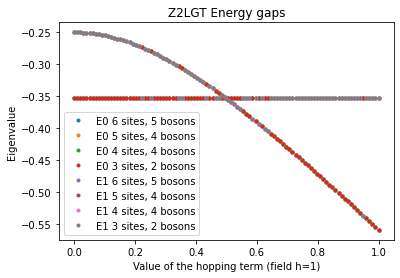

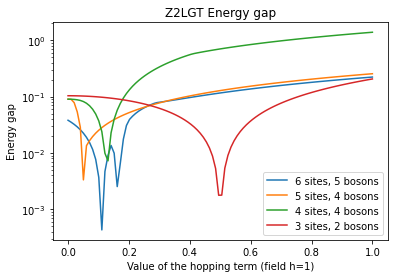

In [42]:
lab = ["6 sites, 5 bosons", "5 sites, 4 bosons", "4 sites, 4 bosons", "3 sites, 2 bosons"]

plt.title("Z2LGT Energy gaps")
for i in range(len(set)):
    plt.plot(energy0[0],energy0[1],".",label="E0 "+lab[i])
for i in range(len(set)):
    plt.plot(energy1[0],energy1[1],".",label="E1 "+lab[i])
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Eigenvalue")
plt.legend()
plt.show()

plt.title("Z2LGT Energy gap")
for i in range(len(set)):
    plt.plot(set[i][0],set[i][1],label=lab[i])
plt.yscale("log")
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Energy gap")
plt.legend()
plt.show()

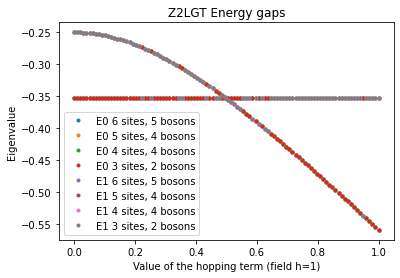

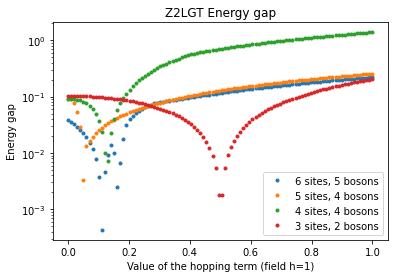

In [41]:
lab = ["6 sites, 5 bosons", "5 sites, 4 bosons", "4 sites, 4 bosons", "3 sites, 2 bosons"]

plt.title("Z2LGT Energy gaps")
for i in range(len(set)):
    plt.plot(energy0[0],energy0[1],".",label="E0 "+lab[i])
for i in range(len(set)):
    plt.plot(energy1[0],energy1[1],".",label="E1 "+lab[i])
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Eigenvalue")
plt.legend()
plt.show()

plt.title("Z2LGT Energy gap")
for i in range(len(set)):
    plt.plot(set[i][0],set[i][1],".",label=lab[i])
plt.yscale("log")
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Energy gap")
plt.legend()
plt.show()

# Energy penalty Gauss's law term (not in use)

In [ ]:
Vvals=[50,100,200]
for Vi in range(len(Vvals)):
    V=Vvals[Vi]
    print("V ",V)
    min_sites=4
    max_sites=5
    set=[]
    for j in range(min_sites,max_sites):
        ###### parameters
        L_modes = j # system size
        L_spin = j-1
        total_boson_number = j
        cutoff = 5
        h = 1 # field strength
        t_min = 0.2 # hopping strength
        t_max = 4
        numberofvaluesof_t = 100
        tvals=np.linspace(t_min,t_max,numberofvaluesof_t)
        ###### create the basis
        # building the two bases to tensor together
        basis_spin = spin_basis_1d(L=L_spin)
        basis_boson=boson_basis_1d(L=L_modes,sps=cutoff,Nb=total_boson_number)
        basis = tensor_basis(basis_spin,basis_boson)
        # print(basis)

        # Different system sizes and number of bosons - choose number of bosons to be equal to the system size

        gj=1
        deltas=np.zeros((2,len(tvals)))
        for i in range(len(tvals)):
            t=tvals[i]
            ##### create model
            hop=[[-t,i,i,i+1] for i in range(L_modes-1)]
            field = [[-h,i] for i in range(L_spin)]
            gausslawxxn=[[2*V,i,i+1,i] for i in range(L_spin-1)]
            gausslawxx=[[-2*gj*V,i,i+1] for i in range(L_spin-1)]
            gausslawnn=[[V,i,i] for i in range(L_modes)]
            gausslawn=[[-2*gj*V,i] for i in range(L_modes)]
            static=[["z|+-",hop],["z|-+",hop],["x|",field],["xx|n",gausslawxxn],["xx|",gausslawxx],["|nn",gausslawnn],["|n",gausslawn]]
            # gausslawxx=[[V,i,i+1] for i in range(L_spin-1)]
            # gausslawn=[[2*gj*V,i] for i in range(L_modes)]
            # static=[["z|+-",hop],["z|-+",hop],["x|",field],["xx|",gausslawxx],["|n",gausslawn]]
            ###### setting up operators
            # set up hamiltonian dictionary and observable (imbalance I)
            no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
            H = hamiltonian(static,[],basis=basis,**no_checks)
            E, _ = H.eigsh(k=2)
            delta=np.abs(E[1]-E[0])
            deltas[0][i]=t
            deltas[1][i]=delta

        set.append(deltas)

    plt.title("Z2LGT Energy gap (1 boson per site) V="+str(V))
    for i in range(len(set)):
        plt.plot(set[i][0],set[i][1],".",label=str(i+min_sites)+" sites")
    plt.xlabel("Value of the hopping term (field h=1)")
    plt.ylabel("Energy gap")
    plt.legend()
    plt.show()